Text(0.5, 1.0, 'Phase')

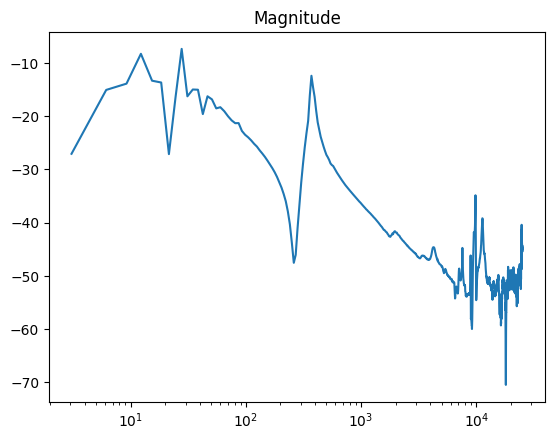

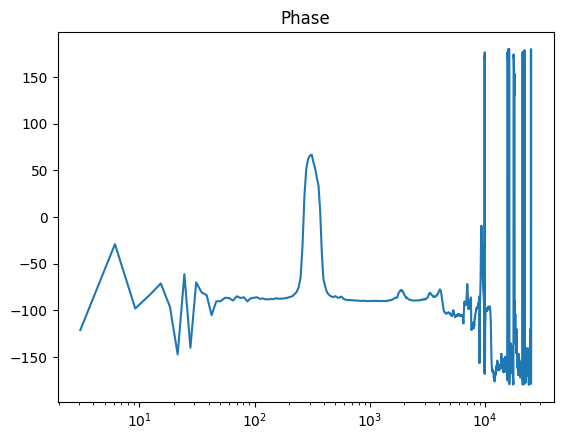

In [18]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')


Y = ast.plant_freq_response.values
mag = np.abs(Y)
phase = np.angle(Y)
omega = ast.plant_freq_response.freqs_hz * 2*np.pi


plt.semilogx(omega, 20*np.log10(mag))
plt.title('Magnitude')

plt.figure()
plt.semilogx(omega, np.rad2deg(phase))
plt.title('Phase')



Text(0.5, 1.0, 'Phase')

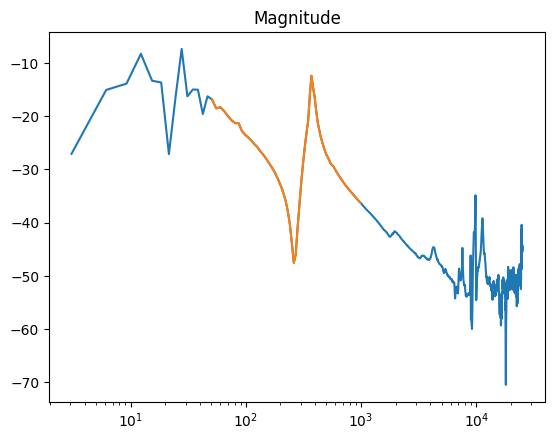

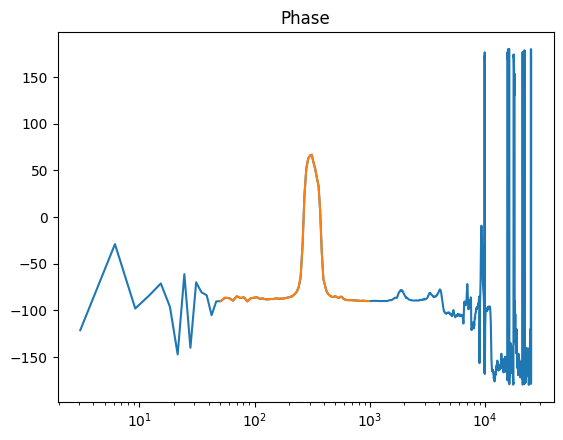

In [19]:
indx = omega > 50
indx1 = omega < 1000
indx = indx & indx1


mag_H = mag[indx]
phase_H = phase[indx]
omega_H = omega[indx]

plt.figure()
plt.semilogx(omega, 20*np.log10(mag))
plt.semilogx(omega_H, 20*np.log10(mag_H))
plt.title('Magnitude')


plt.figure()
plt.semilogx(omega, np.rad2deg(phase))
plt.semilogx(omega_H, np.rad2deg(phase_H))
plt.title('Phase')


<TransferFunction>: sys[128]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-0.0002458 s^3 + 14.47 s^2 + 303.3 s + 1.027e+06
------------------------------------------------
   s^3 + 32.86 s^2 + 1.399e+05 s + 2.933e+05



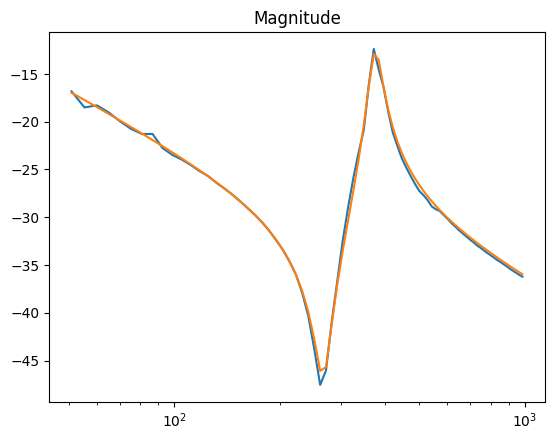

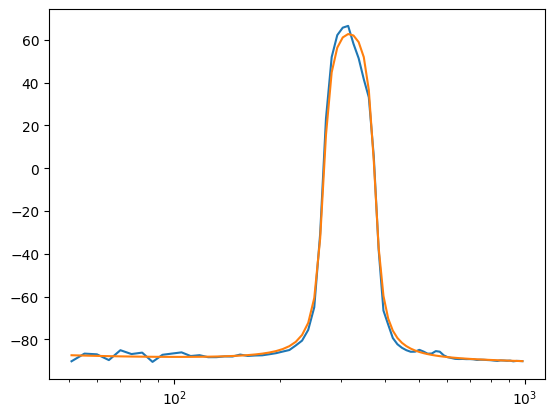

In [20]:
Gi,_,_= tf_freq_id.fit(omega_H, mag_H, phase_H,model_order=4)

Gi = ctrl.tf(Gi)

print(Gi)

GyH = ctrl.frequency_response(Gi, omega_H).response[0][0]

plt.figure()
plt.semilogx(omega_H, 20*np.log10(mag_H))
plt.semilogx(omega_H, 20*np.log10(np.abs(GyH)))
plt.title('Magnitude')

plt.figure()
plt.semilogx(omega_H, np.rad2deg(phase_H))
plt.semilogx(omega_H, np.rad2deg(np.angle(GyH)))


0 states have been removed from the model


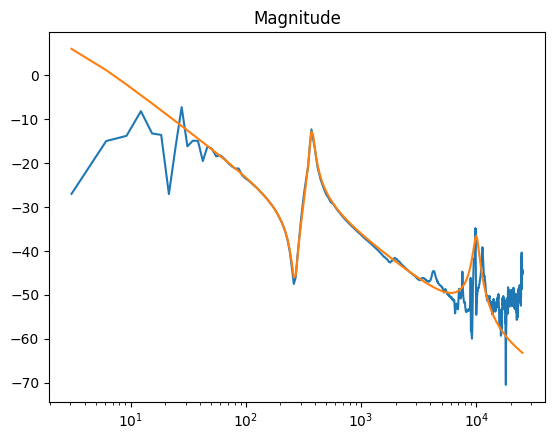

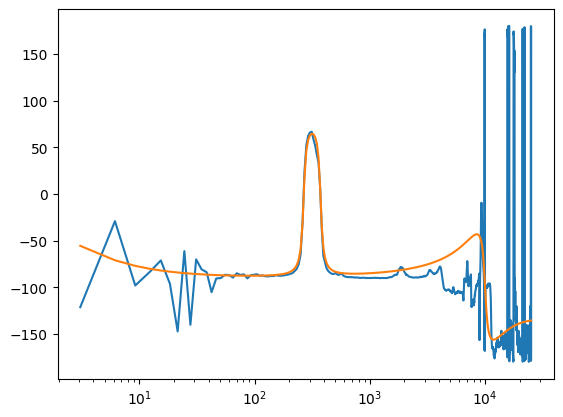

In [21]:
def pt2(omega,zeta):
    return ctrl.tf(omega**2,[1,2*zeta*omega,omega**2])

def notch(omega_n,zeta_n,omega_d,zeta_d):
    return pt2(omega_d,zeta_d)/pt2(omega_n,zeta_n)



G = Gi * pt2(1e4,0.05)/pt2(1e4,0.5)

G = ctrl.minreal(G)

Gy = ctrl.frequency_response(G, omega).response[0][0]

plt.figure()
plt.semilogx(omega, 20*np.log10(mag))
plt.semilogx(omega, 20*np.log10(np.abs(Gy)))
plt.title('Magnitude')

plt.figure()
plt.semilogx(omega, np.rad2deg(phase))
plt.semilogx(omega, np.rad2deg(np.angle(Gy)))

In [22]:
G

TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# Model error (Model uncertainty)

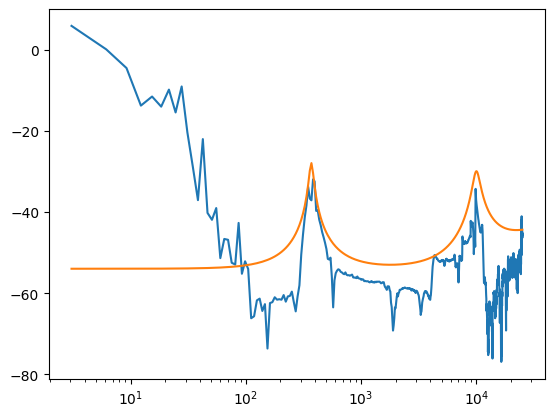

In [23]:


s = ctrl.tf('s')

W_add = 2*1e-3*notch(370,0.8,370,0.04)*notch(1e4,0.8,1e4,0.07) * (s/1e4 + 1) / (s/(5*1e4) + 1)
error = np.abs(Y - Gy)

Wy = ctrl.frequency_response(W_add, omega).response[0][0]

plt.figure()
plt.semilogx(omega, 20*np.log10(error))
plt.semilogx(omega, 20*np.log10(np.abs(Wy)))


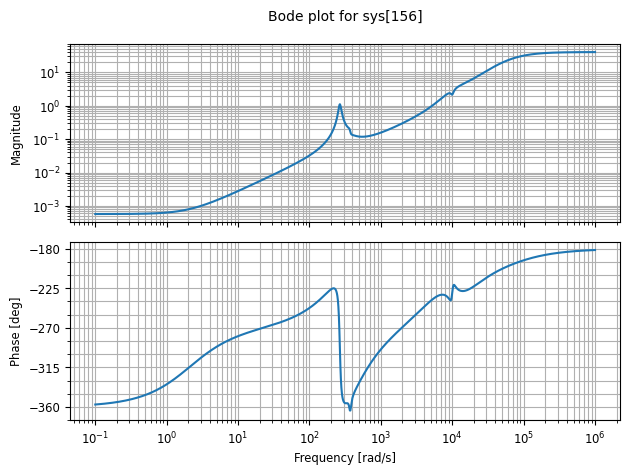

In [24]:
W_delta = W_add/G

ctrl.bode(W_delta)

In [ ]:
def print_tf(tf,f):
    num = tf.num[0][0]
    den = tf.den[0][0]

    #num = np.flip(num)
    #den = np.flip(den)

    f.write(str(num))
    f.write('\n')
    f.write(str(den))

with open(r'tf_txt/W_delta.txt','w') as f:
    print_tf(W_delta,f)

# Checking the avaliable bandwidth from the current controller

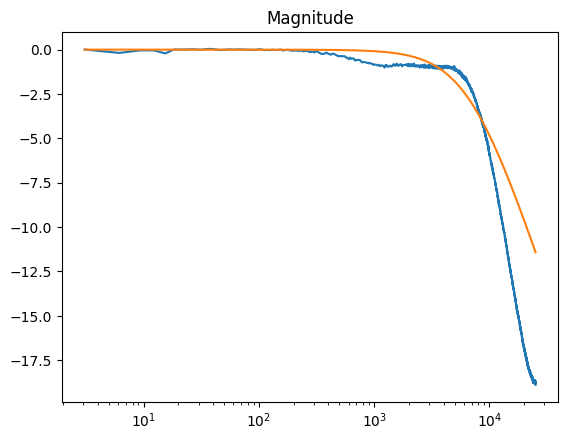

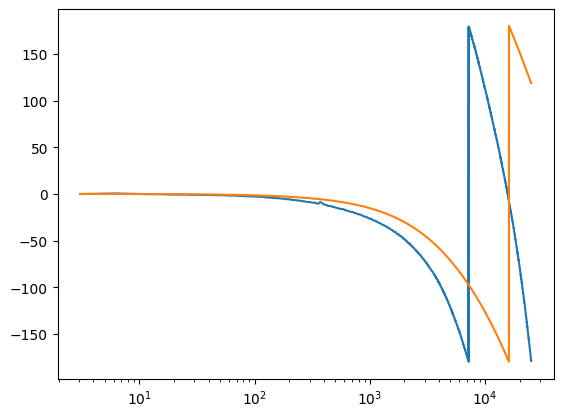

In [26]:


asct_GCY = ast.current_ctrl_freq_response.values
ast_GCY_omega = ast.current_ctrl_freq_response.freqs_hz * 2*np.pi

Gc = pt2(8000,1.0)*tt.sinu_tf.pade(125*1e-6,2)
Gc = 1/(s/7000 + 1)*tt.sinu_tf.pade(125*1e-6,2)

Gcy = ctrl.frequency_response(Gc, ast_GCY_omega).response[0][0]

plt.figure()
plt.semilogx(ast_GCY_omega, 20*np.log10(np.abs(asct_GCY)))
plt.semilogx(ast_GCY_omega, 20*np.log10(np.abs(Gcy)))
plt.title('Magnitude')

plt.figure()
plt.semilogx(ast_GCY_omega, np.rad2deg(np.angle(asct_GCY)))
plt.semilogx(ast_GCY_omega, np.rad2deg(np.angle(Gcy)))


0 states have been removed from the model


TransferFunction(array([-2.45755575e-04,  1.20077395e+01,  1.20380740e+05,  1.45058965e+09,
        4.06012480e+10,  1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

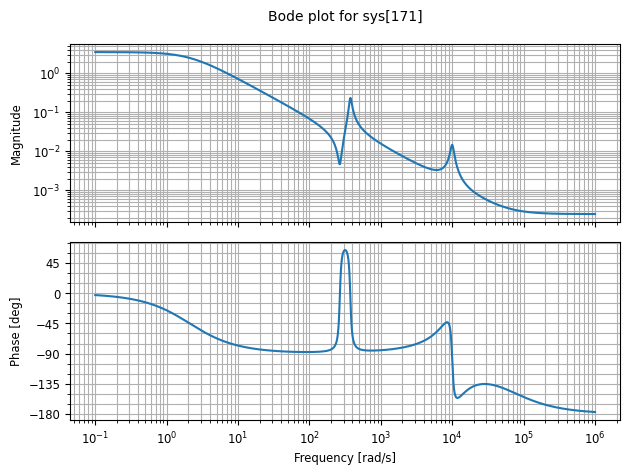

In [ ]:
Gf = Gc*G
Gf = G
Gf = ctrl.minreal(Gf)

with open(r'tf_txt/Gf.txt','w') as f:
    print_tf(Gf,f)

ctrl.bode(Gf)
Gf

# Controller from AST

SpeedCtrl(Kp=22.242147839669272, Ti=0.035, Ts=0.00025, ref_mdl_active=True, ref_mdl_freq=37.567485311159444, ref_mdl_d=0.7071, ref_mdl_delay=0.0, act_value_filters=[], current_setp_filters=[PT2(freq=2000.0, damping=0.7071), SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)])
PT2(freq=2000.0, damping=0.7071)
SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)


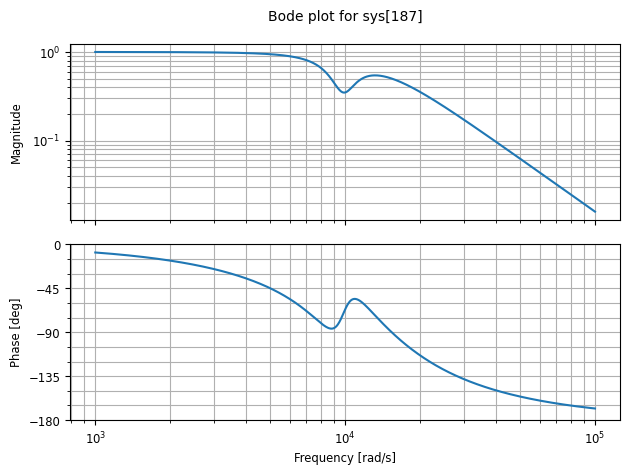

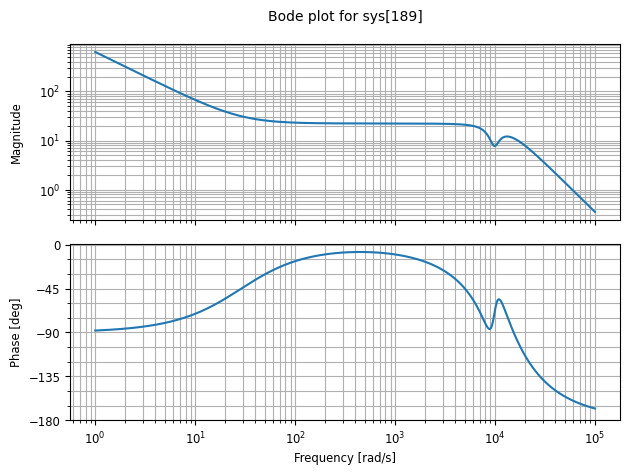

In [28]:
print(ast.speed_ctrl_params)

speed_ctrl = ast.speed_ctrl_params

C = speed_ctrl.Kp*(1 + 1/(s*speed_ctrl.Ti))

assert len(speed_ctrl.act_value_filters) == 0

F = 1 

for filt in speed_ctrl.current_setp_filters:
    print(filt)
    if isinstance(filt,tt.tracetypes.PT2):
        pt2i = tt.sinu_tf.PT2(filt.freq,filt.damping)
        F *= pt2i
    elif isinstance(filt,tt.tracetypes.SecondOrdFilter):
        pt2i = tt.sinu_tf.PT2(filt.den_f,filt.den_d) / tt.sinu_tf.PT2(filt.num_f,filt.num_d)
        F *= pt2i
    else:
        raise Exception('Only PT2 filter supported for now..')
    



ctrl.bode(F)
plt.figure()
ctrl.bode(F*C)



0 states have been removed from the model
10 states have been removed from the model


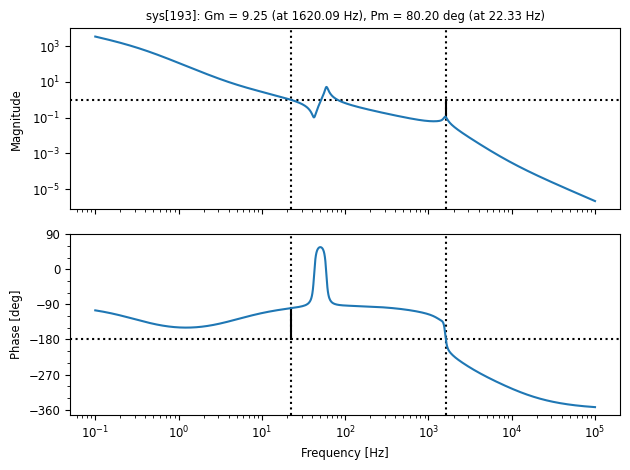

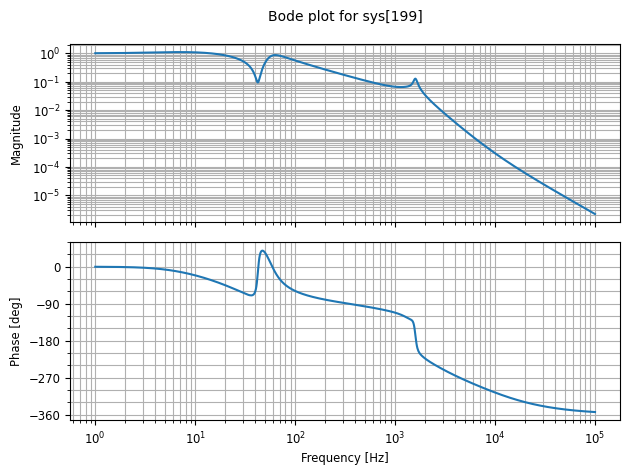

In [29]:

L = C*F*Gf
L = ctrl.minreal(L)

ctrl.bode(L,display_margins=True,Hz=True)   

plt.figure()

CL = L/(1+L)
CL = ctrl.minreal(CL)

ctrl.bode(CL,Hz=True)

# Import Hinf controller

In [30]:


lines = []
with open(r'tf_txt/K_hinf.txt','r') as f:
    lines = f.readlines()
lines

lines = [x.strip().replace('[','').replace(']','') for x in lines]
    

num = [float(x) for x in lines[0].split(',')]
den = [float(x) for x in lines[1].split(',')]

num = np.array(num)
den = np.array(den)

num =  np.flip(num)
den = np.flip(den)

C_hinf = ctrl.tf(num,den)
C_hinf.name = 'Hinf'
C_ast = C*F 
C_ast.name = 'AST'

ctrl.bode(C_hinf)
ctrl.bode(C_ast)

FileNotFoundError: [Errno 2] No such file or directory: 'tf_txt/K_hinf.txt'

5 states have been removed from the model
9 states have been removed from the model


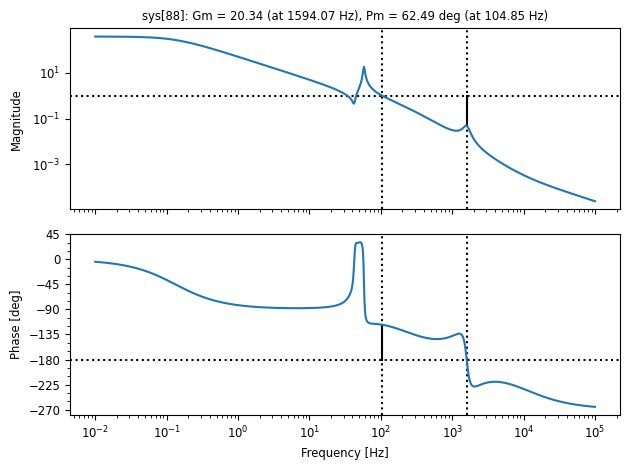

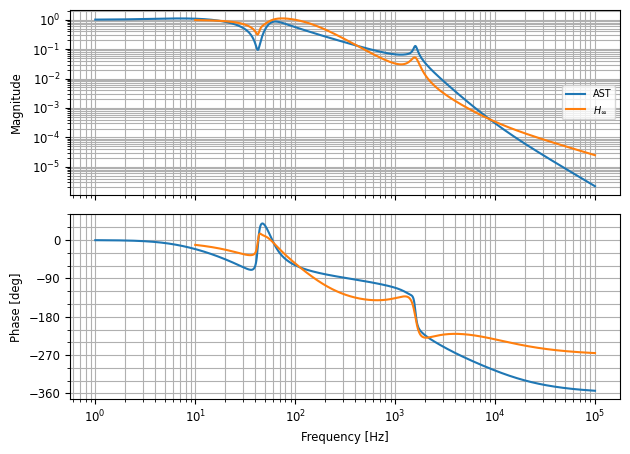

In [ ]:
Lh = C_hinf*Gf
Lh = ctrl.minreal(Lh)

ctrl.bode(Lh,display_margins=True,Hz=True)   

plt.figure()

CLh = Lh/(1+Lh)
CLh = ctrl.minreal(CLh)


CL.name = r'AST'
CLh.name = r'$H_\infty$'

ctrl.bode(CL,Hz=True)
ctrl.bode(CLh,Hz=True)

0 states have been removed from the model
1 states have been removed from the model


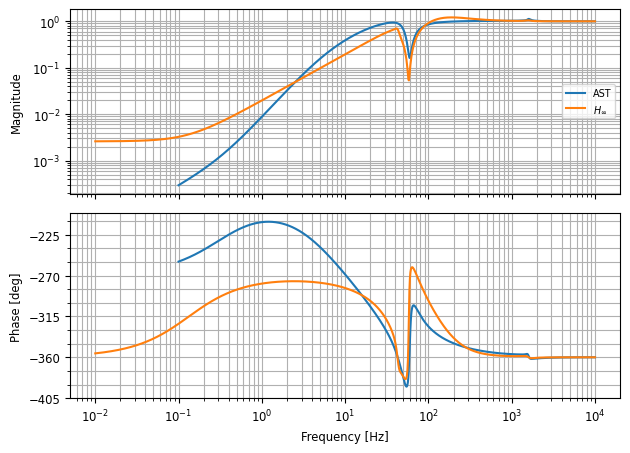

In [ ]:

S_ast = 1/(1+L)
S_hinf = 1/(1+Lh)

S_ast = ctrl.minreal(S_ast)
S_hinf = ctrl.minreal(S_hinf)

S_ast.name = r'AST'
S_hinf.name = r'$H_\infty$'

ctrl.bode(S_ast,Hz=True)
ctrl.bode(S_hinf,Hz=True)

5 states have been removed from the model
5 states have been removed from the model


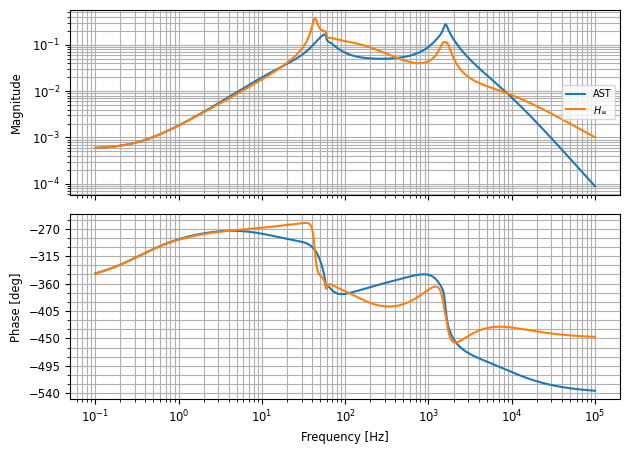

In [ ]:
T_rob = CL *  W_delta
T_rob = ctrl.minreal(T_rob)
T_rob.name = r'AST' 

T_hinf = CLh *  W_delta
T_hinf = ctrl.minreal(T_hinf)
T_hinf.name = r'$H_\infty$'

ctrl.bode(T_rob,Hz=True)
ctrl.bode(T_hinf,Hz=True)


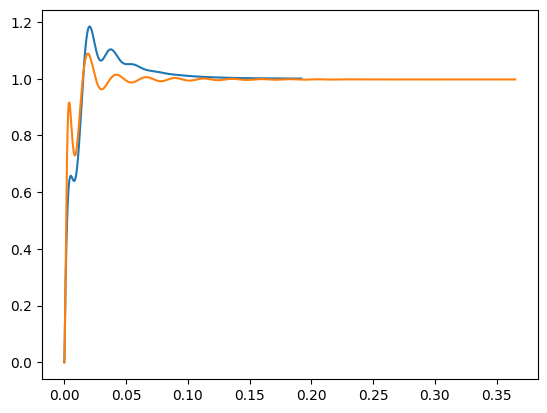

In [ ]:


t0,y0 = ctrl.step_response(CL)
t1,y1 = ctrl.step_response(CLh)

plt.figure()
plt.plot(t0,y0)
plt.plot(t1,y1)

